#**Investigation of *items* database and correlations between items**

**EDA, NLP, Feature Generation**

Andreas Theodoulou and Michael Gaidis (June, 2020)

#Some Summaries of the Code Below

##**Summary of Sales By Day of Week:**

1. Start by grouping all the sales_train data by day of the week (Sun/Mon/Tues/...)
2  Look at how sales vary by day of the week
3. Goal is to count numbers of each type of day of the week in a given month block (0-34), and scale the sales appropriately if there are, e.g., more Saturdays (high sales) in one month than another.

#0. Configure Environment
**NOT OPTIONAL**

In [25]:
# python libraries/modules used throughout this notebook (with some holdovers from other, similar notebooks)
'''
NOTE: selecting a group of code lines and pressing ctrl-/ will toggle commenting of the code lines, for fast and easy disabling/enabling of stuff
'''

# pandas data(database) storage, EDA, and manipulation
import pandas as pd
### pandas formatting
### Adjust as per your preferences.  Here's what I find works well when using a FHD monitor with a full-screen browser window containing my IPynb notebook:
# pd.set_option("display.max_rows",100)     # Override pandas choice of how many rows to show, so we can see the full 84-row item_category df instead of '...' in the middle
# pd.set_option("display.max_columns",30)   # Similar to row code above, we can show more columns than default
# pd.set_option("display.width", 250)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, the drawback is that we will get output text wrapping)
# pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle
### Here's what I find works well for this particular IPynb, when using a FHD laptop monitor with a full-screen browser window containing my IPynb notebook:
pd.set_option("display.max_rows",120)     # Override pandas choice of how many rows to show, so, for example, we can see the full 84-row item_category dataframe instead of the first few rows, then ...., then the last few rows
pd.set_option("display.max_columns",26)   # Similar to row code above, we can show more columns than default  
pd.set_option("display.width", 230)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, the drawback is that we will get output text wrapping)
pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle

# pd.set_option("display.precision", 3)  # Nah, this is helpful, but below is even better
# Try to convince pandas to print without decimal places if a number is actually an integer (helps keep column width down, and highlights data types), or with precision = 3 decimals if a float
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)

# Pandas additional enhancements
pd.set_option('compute.use_bottleneck', False)  # speed up operation when using NaNs
pd.set_option('compute.use_numexpr', False)     # speed up boolean operations, large dataframes; DataFrame.query() and pandas.eval() will evaluate the subexpressions that can be evaluated by numexpr


# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# ipynb magic command to allow interactive matplotlib graphics in ipynb notebook
%matplotlib inline  
# a useful reference of contrasting color choices to use when plotting multiple things on a single axis
pltcolors = ['blue','red','green','black','darkorange','fuchsia','teal','gold','violet','olive','firebrick','gray','cyan','sienna','dodgerblue','lime','darkorchid','deeppink','turquoise','tan']
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from IPython.display import Javascript      # used to properly code the creation of sns heatmaps in IPynb with Google Colab
from IPython.display import display_html    # used to print out side-by-side dataframes, for example

# computations
import numpy as np
from scipy import sparse
from numba import jit, prange  # speedup for appropriate functions and datatypes (no sets, lists, dictionaries, string functions; use np arrays rather than pandas series or dataframes)
#  If you want Numba to throw an error if it cannot compile a function in a way that speeds up your code, pass the argument nopython=True (e.g. @jit(nopython=True))
from numba import vectorize  # speed up row-wise operations like .apply() --> https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html
# can also do np.vectorize (see pandas 1.0.3 documentation section on enhancing speed of pandas operations)

# file operations
import os
import feather   # this is 3x to 8x faster than pd.read_csv and pd.to_hdf, but file size is 2x hdf and 10x csv.gz
import pickle
import json
from urllib.parse import urlunparse
from pathlib import Path

# misc. python enhancements
# note: for a quick look at what's available for magic commands in this ipynb, enter this into a code cell: '%quickref'
import re
import string
from itertools import product
from collections import OrderedDict
import time
import datetime
from time import sleep, localtime, strftime, tzset, strptime
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()


# Specialized packages
# -- for network analysis / graphs / clustering (a reasonable alternative to pca, tSNE, or Knn clustering when number of dimensions is huge)
# import networkx as nx
# from networkx.algorithms import community, cluster
# -- NLP packages ... for now, as of 5/29/20, only using the lemmatizer, due to the 
# import nltk
# nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer 
# lemmatizer = WordNetLemmatizer() 

# ML packages
import sklearn
# from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# !pip install catboost
# from catboost import CatBoostRegressor
# %tensorflow_version 2.x
# import tensorflow as tf
# import keras as K

# # List of the modules we need to version-track for reference
modules = ['pandas','matplotlib','numpy','scipy','numba','seaborn','sklearn','tensorflow','keras','catboost','pip','nltk','networkx']
print(f'done: {strftime("%a %X %x")}')

done: Thu 16:25:05 06/11/20


#0.1) Mount Google Drive (Local File Storage/Repo)

In [26]:
# click on the URL link presented to you by this command, get your authorization code from Google, then paste it into the input box and hit 'enter' to complete mounting of the drive
from google.colab import drive  
drive.mount('/content/drive')
print(f'done: {strftime("%a %X %x")}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
done: Thu 16:25:06 06/11/20


#1. Load Data Files



##1.1) Enter Data File Names and Paths

**NOT Optional**

In [27]:
#  Except for fast-loading (large filesize) feather format files, 
#   the data is coming from a public repo on GitHub at github.com/migai/Kag that has been synced to my local repo on Google Drive

'''
############################################################
############################################################
'''
# Replace this path with the path on *your* Google Drive where the repo master branch is stored
#   (on GitHub, the remote repo is located at github.com/migai/Kag --> below is my cloned repo location)
GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
OUT_OF_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final"   # place > 100MB files here, because they won't sync with GitHub

testtrain_mrg_loaded = False   # set this to True if you plan to load the .ftr or the .csv.gz version of the testtrain_mrg dataframe, and skip the calculations below that generated it
tt_loaded = True #False #True
ftr_file_load_employed = True #False #True  # set to True if you wish to load the .ftr version or the .csv.gz version... it's faster, but its a 10x larger file, and won't work in the GitHub repo push


# if using large feather file for fast loading, use the routine here
#   note that this is too large to push to GitHub, so if you want to go this route, 
#   you'll first have to load (more slowly) the 'data_output/testtrain_mrg.csv.gz' file 
#   with pandas read_csv, and then store the file as feather type (outside your local GitHub repo)
#   Or, you can just recreate the dataframe by running the first few code cells that do merging and data manipulation
# load feather files manually for now
if (testtrain_mrg_loaded and ftr_file_load_employed):
    print('ftr files source directory: ', end='')
    %cd "{OUT_OF_REPO_PATH}"
    testtrain_mrg = pd.read_feather('testtrain_mrg.ftr', columns=None, use_threads=True)
    print("Loading ftr Files from Google Drive (outside repo) into Colab... \n\nData Frame: testtrain_mrg (from ftr)")
    print(testtrain_mrg.head(2))
if (tt_loaded and ftr_file_load_employed):
    print('ftr files source directory: ', end='')
    %cd "{OUT_OF_REPO_PATH}"
    tt = pd.read_feather('tt.ftr', columns=None, use_threads=True)
    print("Loading ftr Files from Google Drive (outside repo) into Colab... \n\nData Frame: tt (from ftr)")
    print(tt.head(2))

'''
############################################################
############################################################
'''

data_files = []
# List of the data files (path relative to GitHub master), to be loaded into pandas DataFrames
if (testtrain_mrg_loaded and not ftr_file_load_employed):
    data_files = [  "data_output/testtrain_mrg.csv.gz" ]

if (tt_loaded and not ftr_file_load_employed):
    data_files = [  "data_output/tt.csv.gz" ]
                
data_files += [  #"readonly/final_project_data/shops.csv",
                #"data_output/shops_transl.csv",
                "data_output/shops_augmented.csv",
                "data_output/shops_new.csv",
               
                #"readonly/final_project_data/items.csv",
                "data_output/items_transl.csv",
                "data_output/items_augmented.csv",
                "data_output/items_new.csv",
                #"data_output/items_clustered_22170.csv.gz",
               
                #"readonly/final_project_data/item_categories.csv",
                "data_output/item_categories_transl.csv",
                "data_output/item_categories_augmented.csv",
                #"readonly/en_50k.csv",
               
                "readonly/final_project_data/sales_train.csv.gz",
                #"data_output/sales_train_cleaned.csv.gz",
               
                #"readonly/final_project_data/sample_submission.csv.gz",
                "readonly/final_project_data/test.csv.gz"
                ]


# Dict of helper code files, to be loaded and imported {filepath : import_as}
code_files = {}  # not used at this time; example dict = {"helper_code/kaggle_utils_at_mg.py" : "kag_utils"}


# GitHub file location info
git_hub_url = "https://raw.githubusercontent.com/migai"
repo_name = 'Kag'
branch_name = 'master'
base_url = os.path.join(git_hub_url, repo_name, branch_name)

print(f'\nDone: {strftime("%a %X %x")}')

ftr files source directory: /content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final
Loading ftr Files from Google Drive (outside repo) into Colab... 

Data Frame: tt (from ftr)
   day day_of_week  day_of_month  week  quarter  season  month  price  sales  shop_id  item_id                                      item_name  it_test  item_category_id   item_category_name  it_cat_test item_cat3 item_cat4  \
0    0     Tuesday             1     0        0       2      0     99      1        2      991      3D Action Puzzle "Dinosaur" Tyrannosaurus    False                67  Gifts - Development         True     Gifts     Gifts   
1    0     Tuesday             1     0        0       2      0   2599      1        2     1472  Assassin's Creed 3 [Xbox 360 Russian version]    False                23     Games - XBOX 360         True     Games      Xbox   

          shop_name sh_cat  sh_test district    fd_popdens fd_gdp    city  population  
0  Adygea TC "Mega"   Mega     True    So

##1.2) Read Data Files from Google Drive local repo

In [28]:
%%time
# 4.5sec with csv and csv.gz files (including conversion to datetime)
# 3.6sec with csv and csv.gz files (no datetime conversion)
if data_files:
    print('\n\ncsv files source directory: ', end='')
    %cd "{GDRIVE_REPO_PATH}"

    print("\nLoading csv Files from Google Drive repo into Colab...\n")

    # Loop to load the data files into appropriately-named pandas DataFrames
    for path_name in data_files:
        filename = path_name.rsplit("/")[-1]
        data_frame_name = filename.split(".")[0]
        exec(data_frame_name + " = pd.read_csv(path_name)")
        # if data_frame_name == 'sales_train':
        #     sales_train['date'] = pd.to_datetime(sales_train['date'], format = '%d.%m.%Y')
        print(f'DataFrame {data_frame_name}, shape = {eval(data_frame_name).shape} :')
        print(eval(data_frame_name).head(2))
        print("\n")
else: 
    %cd "{GDRIVE_REPO_PATH}"
    
print(f'\nDataFrame Loading Complete: {strftime("%a %X %x")}\n')



csv files source directory: /content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag

Loading csv Files from Google Drive repo into Colab...

DataFrame shops_augmented, shape = (60, 8) :
                       shop_name  shop_id                       en_shop_name shop_city shop_category shop_federal_district  shop_city_population  shop_tested
0  !Якутск Орджоникидзе, 56 фран        0  ! Yakutsk Ordzhonikidze, 56 Franc   Yakutsk          Shop               Eastern                235600        False
1  !Якутск ТЦ "Центральный" фран        1       ! Yakutsk TC "Central" Franc   Yakutsk          Mall               Eastern                235600        False


DataFrame shops_new, shape = (60, 14) :
   shop_id  shop_tested shop_type  shop_type_enc shop_city  shop_city_enc shop_federal_district  shop_federal_district_enc s_type_broad  s_type_broad_enc fd_popdens  fd_popdens_enc        fd_gdp  fd_gdp_enc
0        0        False      Shop             20   Yakutsk            

#2. Merge Data Sets, Clean a Little, Create Additional Time-Based Features
(for finer control over time lags)

In [29]:
if not (testtrain_mrg_loaded or tt_loaded):  # we already have this loaded from feather file (1.5sec) or csv.gz (5sec)  (12sec by CPU if redoing these merges)
    # remove outlier rows from training set, but don't merge or delete any shops yet
    sales_train_cleaned0 = sales_train.copy(deep=True)
    print(f'Len sales_train = {len(sales_train_cleaned0):,d}')
    print('Rows being deleted:')
    for i in [2909818,2909401,2326930,2257299,1163158,484683]:
        print(sales_train_cleaned0[sales_train_cleaned0.index == i])
        sales_train_cleaned0.drop(sales_train_cleaned0.index[i],inplace=True)
    print(f'Len sales_train_cleaned0 (after outliers removed): {len(sales_train_cleaned0):,d}')
    
    # Merge the 3 shops we are nearly certain must correctly fit into the other shops' dropout regions:
    sales_train_cleaned0['shop_id'] = sales_train_cleaned0.shop_id.apply(lambda x: 57 if x == 0 else x)
    sales_train_cleaned0['shop_id'] = sales_train_cleaned0.shop_id.apply(lambda x: 58 if x == 1 else x)
    sales_train_cleaned0['shop_id'] = sales_train_cleaned0.shop_id.apply(lambda x: 10 if x == 11 else x)
    print(f'Len sales_train_cleaned0 (after shops 0,1,11 merged into 57,58,10): {len(sales_train_cleaned0):,d}')


    # print(sales_train_cleaned0.shop_id.nunique())
    # sales_train_cleaned0 = sales_train_cleaned0[sales_train_cleaned0.shop_id != 9]
    # print(len(sales_train_cleaned0))
    # sales_train_cleaned0 = sales_train_cleaned0[sales_train_cleaned0.shop_id != 13]
    # print(len(sales_train_cleaned0))

    sales_train_cleaned0 = sales_train_cleaned0.astype({'date_block_num':np.int8,'shop_id':np.int8,'item_id':np.int16,
                                'item_price':np.float32,'item_cnt_day':np.int16}).reset_index(drop=True)

    # merge dataframes so we can do closer analysis of item dependence on shop and categories
    test_prep = test.copy(deep=True)
    test_prep['date_block_num'] = 34
    test_prep['date'] = '30.11.2015' #pd.Timestamp(year=2015, month=11, day=30)
    sales_traintest_clean_mrg = sales_train_cleaned0.append(test_prep).fillna(0)
    #sales_traintest_clean_mrg['date'] = pd.to_datetime(sales_traintest_clean_mrg['date'], format = '%d.%m.%Y')
    sales_traintest_clean_mrg['date'] =  pd.to_datetime(sales_traintest_clean_mrg['date'], dayfirst=True)
    testtrain_mrg = sales_traintest_clean_mrg.merge(items_new[['item_id','item_category_id','item_tested']],on='item_id',how='left').reset_index(drop=True)
    testtrain_mrg = testtrain_mrg.merge(items_transl[['item_id','en_item_name']],on='item_id',how='left').reset_index(drop=True)
    testtrain_mrg = testtrain_mrg.merge(item_categories_augmented[['item_category_id','en_cat_name','item_cat_tested','item_category3','item_category4']],on='item_category_id',how='left').reset_index(drop=True)
    testtrain_mrg = testtrain_mrg.merge(shops_augmented[['shop_id', 'en_shop_name', 'shop_city', 'shop_federal_district',  'shop_city_population',  'shop_tested']], on='shop_id',how='left').reset_index(drop=True)
    testtrain_mrg = testtrain_mrg.merge(shops_new[['shop_id', 'shop_type', 'fd_popdens',  'fd_gdp']], on='shop_id',how='left').reset_index(drop=True)
    testtrain_mrg = testtrain_mrg[['date', 'date_block_num', 'item_price', 'item_cnt_day', 'shop_id', 'item_id', 'en_item_name', 'item_tested', 'item_category_id', 'en_cat_name', 'item_cat_tested',
                                'item_category3', 'item_category4', 'en_shop_name', 'shop_type','shop_tested', 'shop_federal_district', 'fd_popdens', 'fd_gdp', 'shop_city', 'shop_city_population']]
    testtrain_mrg.columns = ['date', 'month', 'price', 'sales', 'shop_id', 'item_id', 'item_name', 'it_test', 'item_category_id', 'item_category_name', 'it_cat_test', 'item_cat3', 'item_cat4', 
                            'shop_name', 'sh_cat', 'sh_test', 'district', 'fd_popdens', 'fd_gdp', 'city', 'population']
                    

    #testtrain_mrg.date = testtrain_mrg.date.apply(lambda x: tuple(int(i) for i in x.split("-")) )  # feather data format will not support lists or tuples as dataframe elements; move this below

    # # optional save file as feather type (big file; don't store inside repo) and/or csv.gz type (inside repo)
    # %cd "{OUT_OF_REPO_PATH}"
    # testtrain_mrg.to_feather('testtrain_mrg.ftr')
    # print("testtrain_mrg.ftr feather file stored on google drive, outside repo")
    # %cd "{GDRIVE_REPO_PATH}"
    # # alternative, or, in addition, can save as csv.gz for < 100 MB storage and sync with GitHub
    # compression_opts = dict(method='gzip',
    #                         archive_name='testtrain_mrg.csv')  
    # testtrain_mrg.to_csv('data_output/testtrain_mrg.csv.gz', index=False, compression=compression_opts)
    # print("testtrain_mrg.csv.gz file stored on google drive in data_output directory")

    print(f'\ntesttrain_mrg done: {strftime("%a %X %x")}\n')
    #testtrain_mrg.tail(2)

def create_time_columns(string_date_dataframe, day0 = datetime.datetime(2013,1,1)):
    """
    Given a dataframe with a 'date' column containing strings like '2015-10-30', create new time-series columns:
    1. 'day'    = integer value of day number, starting at day = 0 for parameter day0, and incrementing by calendar day number (not by transaction day number)... 
                    Thus, 'day' may not include all possible integers from start to finish.  It only assigns integer values (based on the calendar) to days when 
                    there are transactions in the input dataframe --> if the input dataframe has no transactions on a particular day, that day's 'calendar' integer value will not be present in the column (will be = 0)
                    day_of_week = by name, Sunday, Monday, ...
                    day_of_month = 1-31
    2. 'week'   = integer value of week number, with week = 0 at time= parameter day0.  However, unlike 'day', the 'week' number is aligned not to start at day0, but rather
                    so that there is a full 'week' of 7 days that ends on Oct. 31, 2015 (the final day of training data).  This results in week = 0 having only 5 days in it.
                    n.b., the final week of October, 2015 is assigned 'week' number = 147.  week = 0 includes day0.  artifically assigning test to Nov. 30, 2015 results in test week = 152 (including only Nov 29 and 30)
    3. 'month'  = renamed "date_block_num" from original data set; no changes made.  Integer values from 0 to 33 represent the months starting at day0.  month=34 is Nov. 2015, and is the test month.
    4. 'quarter' = integer number of 3-month chunks of time, aligned with the end of October, 2015.  day0 is included in 'quarter' = 0, but 'quarter'=0 only contains 1 month (Jan 2013) of data due to the alignment
                    The months of August, Sept, Oct 2015 form 'quarter' = 11.  "Quarter" in this sense is just 3-month chunks... it is not the traditional Q1,Q2,Q3,Q4 beginning Jan 1, but instead is more like
                    date_block_num in that it is monotonically increasing integers, incremented every 3 months such that #11 ends at the end of our training data
    5. 'season' = integer number of 3-month chunks of time, reset each year (allowed values = 0,1,2,3)... not quite the same as spring-summer-winter-fall, or Q1,Q2,Q3,Q4, but instead shifted to 
                    better capture seasonal spending trends aligned in particular with high December spending
                    2 = Dec 1 to Feb 28 (biggest spending season), 3 = Mar 1 to May 31, 0 = June 1 to Aug 30 (lowest spending season), 1 = Sept 1 to Nov 30

    Finally, drop the date column from the dataframe, and sort the dataframe by ['day','shop_id','item_id']  (original dataframe seems to be sorted by month, but unsorted within each month)
    """

    tt = string_date_dataframe.copy(deep=True)
    tt.date = tt.date.apply(lambda x: datetime.datetime(x.year,x.month,x.day))
    tt.insert(1,'day',0)
    tt.insert(2,'day_of_week',0)
    tt.insert(3,'day_of_month',0)
    tt.insert(4,'week',0)
    tt.insert(5,'quarter',0)
    tt.insert(6,'season',0)  
    tt.day = tt.date.apply(lambda x: (x - day0).days)  # 2.5 sec
    # lambda x: (x.weekday()+1)%7 )  # 0=Sunday, 1=Monday, ... 6= Saturday   # use x.strftime('%A') to get text string day of the week (Sunday, Monday, ...), %a to get Sun, Mon,...
    tt.day_of_week = tt.date.apply(lambda x: x.strftime('%A'))     
    tt.day_of_month = tt.date.apply(lambda x: x.day)
    tt.week = (tt.day+2) // 7           # add the 2 days so we have end of a week coinciding with end of training data Oct. 31, 2015
    tt.quarter = (tt.month + 2) // 3    # add the 2 months so we have end of a quarter aligning with end of training data Oct. 31, 2015
    tt.season = (tt.month + 2) % 4
    tt.drop('date',axis=1,inplace=True)
    tt = tt.sort_values(['day','shop_id','item_id']).reset_index(drop=True)  # note that the train dataset is sorted by month, but nothing obvious within the month; we sort it here for consistent results in calculations below
    print(f'tt dataframe creation done: {strftime("%a %X %x")}\n')
    return tt

print(f'\nDone: {strftime("%a %X %x")}\n')


Done: Thu 16:25:10 06/11/20



In [30]:
if not tt_loaded:
    print(f'tt dataframe creation started: {strftime("%a %X %x")}\n')
    tt = create_time_columns(testtrain_mrg)

    # optional save file as feather type (big file; don't store inside repo) and/or csv.gz type (inside repo)
    %cd "{OUT_OF_REPO_PATH}"
    tt.to_feather('tt.ftr')
    print("tt.ftr feather file stored on google drive, outside repo")
    %cd "{GDRIVE_REPO_PATH}"
    # alternative, or, in addition, can save as csv.gz for < 100 MB storage and sync with GitHub
    compression_opts = dict(method='gzip',
                            archive_name='tt.csv')  
    tt.to_csv('data_output/tt.csv.gz', index=False, compression=compression_opts)
    print("tt.csv.gz file stored on google drive in data_output directory")
    print(f'tt file save done: {strftime("%a %X %x")}')

display(tt[tt.week == 102].tail(2))
print(f'\ntt done: {strftime("%a %X %x")}')

,day,day_of_week,day_of_month,week,quarter,season,month,price,sales,shop_id,item_id,item_name,it_test,item_category_id,item_category_name,it_cat_test,item_cat3,item_cat4,shop_name,sh_cat,sh_test,district,fd_popdens,fd_gdp,city,population
2257039,718,Saturday,20,102,8,1,23,399,1,59,21970,Shar predictor soccer ball,False,69,Gifts - Souvenirs,True,Gifts,Gifts,"Yaroslavl shopping center ""Altair""",SEC,True,Central,Populous,Intermediate,Yaroslavl,606730
2257040,718,Saturday,20,102,8,1,23,499,1,59,22060,EPIC (BD),True,37,Movie - Blu-Ray,True,Movies,Movies,"Yaroslavl shopping center ""Altair""",SEC,True,Central,Populous,Intermediate,Yaroslavl,606730



tt done: Thu 16:25:10 06/11/20


#3. EDA related to weekly periodicity of overall sales (Sun/Mon/Tues...)

tt DataFrame shape: (3150043, 26)
tt DataFrame shape after grouping by week: (149, 2)



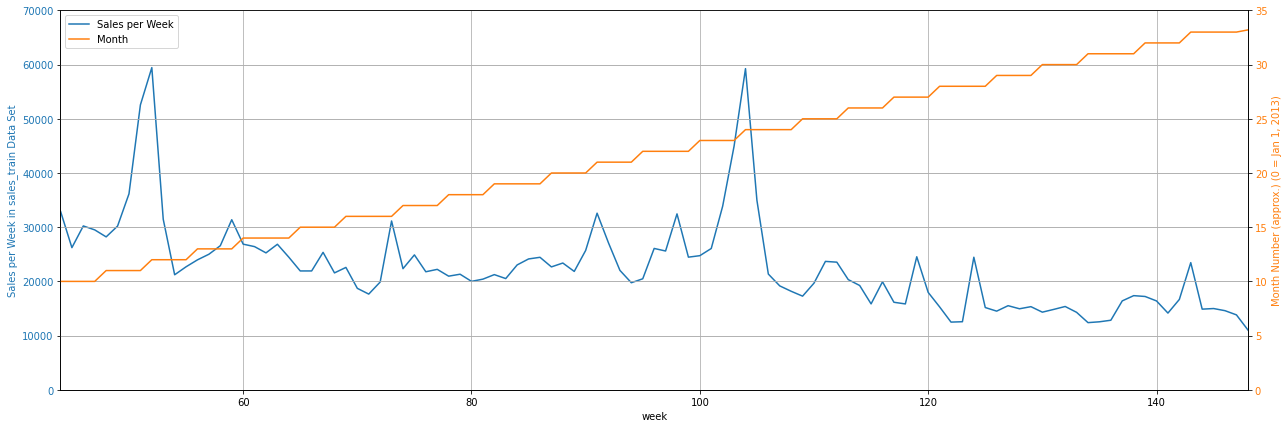

In [31]:
# Let's look at all sales_train sales per week, near Christmas 2014
# week 100-104 = month 23, week 96 to 99 = month 22, week 105-108 = month 23

print(f'tt DataFrame shape: {tt.shape}')
dfweek = tt.groupby(['week']).agg({'month':'max', 'sales':'sum'})
print(f'tt DataFrame shape after grouping by week: {dfweek.shape}\n')

fig, ax1 = plt.subplots(figsize=(18,6))

color = 'tab:blue'
ax1.set_xlabel('Week Number (0 = Jan 1, 2013)')
ax1.set_ylabel('Sales per Week in sales_train Data Set', color=color)
p1=dfweek.plot(y='sales',kind='line',grid=True,color=color,ax=ax1,label='Sales per Week',legend=None)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a right axis that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Month Number (approx.) (0 = Jan 1, 2013)', color=color)
p2=dfweek.plot(y='month',kind='line',grid=True,color=color,ax=ax2,label='Month',legend=None)
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax1.set_ylim(0, 70000)
ax2.set_ylim(0, 35)
ax1.set_xlim(44, 148)
plt.show()

(1035, 6)


,day,day_of_week,month,week,day_of_month,sales
285,285,Sunday,9,41,13,4943
286,286,Monday,9,41,14,2825
287,287,Tuesday,9,41,15,2923
288,288,Wednesday,9,41,16,2842
289,289,Thursday,9,41,17,3110
290,290,Friday,9,41,18,3772
291,291,Saturday,9,41,19,6056
292,292,Sunday,9,42,20,4717
293,293,Monday,9,42,21,2328
294,294,Tuesday,9,42,22,2274


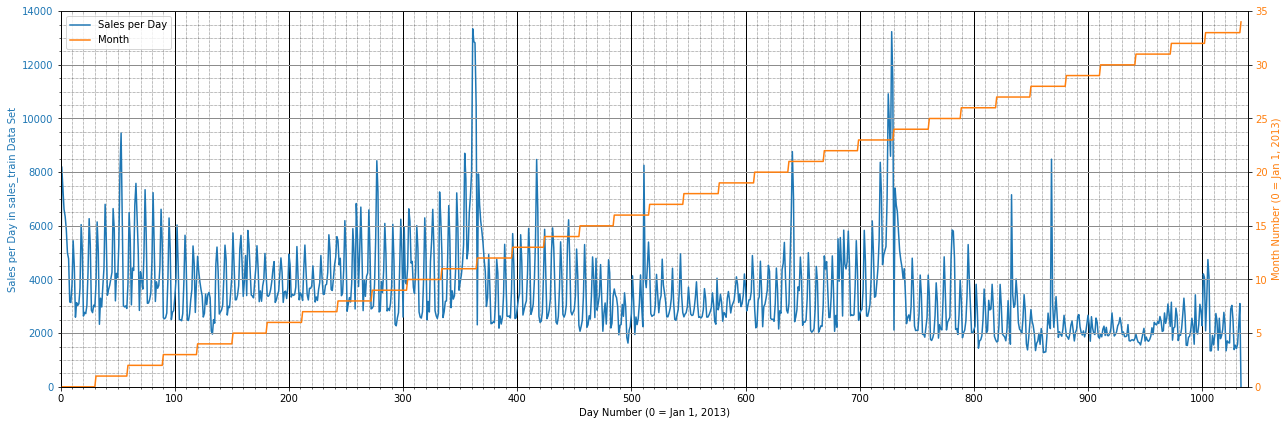

In [32]:
# Now, instead of grouping by week, let's group sales by day
dfday = tt.groupby(['day','day_of_week']).agg({'month':'mean', 'week':'mean','day_of_month':'mean','sales':'sum'}).reset_index()
print(dfday.shape)
display(dfday.iloc[285:300,:].head(10))
print('\n')

fig, ax1 = plt.subplots(figsize=(18,6))

color = 'tab:blue'
ax1.set_xlabel('Day Number (0 = Jan 1, 2013)')
ax1.set_ylabel('Sales per Day in sales_train Data Set', color=color)
p1=dfday.plot(y='sales',kind='line',grid=True,color=color,ax=ax1,label='Sales per Day',legend=None)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a right axis that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Month Number (0 = Jan 1, 2013)', color=color)
p2=dfday.plot(y='month',kind='line',grid=True,color=color,ax=ax2,label='Month',legend=None)
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Turn on the minor ticks, which are required for the minor grid
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='1.0', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax1.set_xticks( list(range(0,1040,10)), minor=True )
ax1.set_xticks( list(range(0,1040,100)))
ax1.set_ylim(0, 14000)
ax2.set_ylim(0, 35)
ax1.set_xlim(0, 1040)
plt.show()


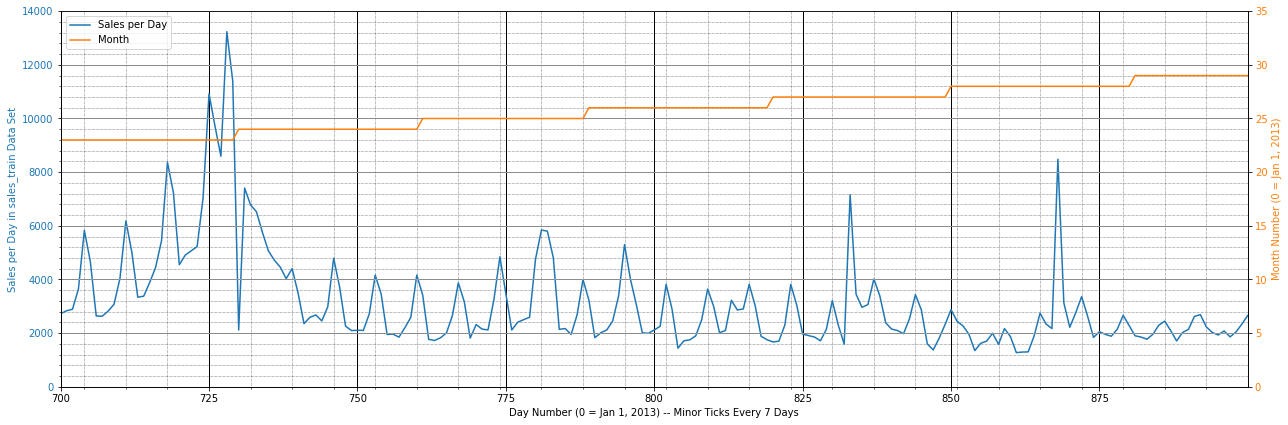

In [33]:
# Zoom in on an interesting region
fig, ax1 = plt.subplots(figsize=(18,6))

color = 'tab:blue'
ax1.set_xlabel('Day Number (0 = Jan 1, 2013) -- Minor Ticks Every 7 Days')
ax1.set_ylabel('Sales per Day in sales_train Data Set', color=color)
p1=dfday.plot(y='sales',kind='line',grid=True,color=color,ax=ax1,label='Sales per Day',legend=None)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a right axis that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Month Number (0 = Jan 1, 2013)', color=color)
p2=dfday.plot(y='month',kind='line',grid=True,color=color,ax=ax2,label='Month',legend=None)
ax2.tick_params(axis='y', labelcolor=color)

fig.legend(loc='upper left', bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Turn on the minor ticks, which are required for the minor grid
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='1.0', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax1.set_xticks( list(range(697,900,7)), minor=True )
ax1.set_yticks( list(range(0,14000,400)), minor=True )
ax1.set_xticks( list(range(700,900,25)))
ax1.set_ylim(0, 14000)
ax2.set_ylim(0, 35)
ax1.set_xlim(700, 900)
plt.show()

,quarter,day_of_week,sales,mean,std
0,0,Friday,18372,1.152,0.720
1,0,Monday,13067,1.101,0.504
2,0,Saturday,24100,1.157,0.698
3,0,Sunday,20717,1.144,0.675
4,0,Thursday,19662,1.120,0.573


quarter,1,2,3,4,5,6,7,8,9,10,11
day_of_week,,,,,,,,,,,
Sunday,68118,55435,64777,76524,58719,42310,52596,65380,43634,28791,32293
Monday,37022,39526,40218,51996,33568,31659,32710,45942,28261,24724,22794
Tuesday,44079,41729,49236,51368,35307,38508,34734,53417,30781,31197,29230
Wednesday,39702,48712,46678,42720,36465,36970,35382,49387,28624,25517,26725
Thursday,45698,45040,50434,50427,35458,42412,40892,44161,28687,25434,25318


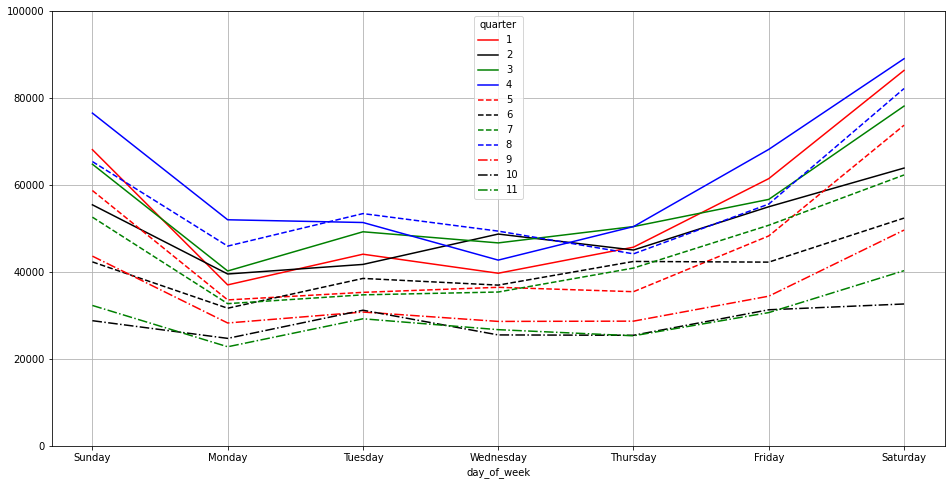

In [34]:
# Now, let's group by quarter instead of taking the sales for every day in the training set
#   but, also group by day of week, so we will see how big the weekly peaks (seen in plot above)
#   are for each quarter from 2013 to 2015

dfqDoW = tt.groupby(['quarter','day_of_week']).agg({'sales':['sum','mean','std']}).reset_index()
dfqDoW.columns = ['quarter','day_of_week','sales','mean','std']
display(dfqDoW.head())
print('\n')
dfqDoWpiv = pd.pivot(dfqDoW,'day_of_week','quarter','sales').drop([0,12],axis=1)   # quarter 0 is only 1 month long; quarter 12 starts with month 34 (0 sales)
dfqDoWpiv = dfqDoWpiv.reindex(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
display(dfqDoWpiv.head())
print('\n')

color = ['red','black','green','blue','red','black','green','blue','red','black','green']
linestyles = ['-','-','-','-','--','--','--','--','-.','-.','-.']
ax = dfqDoWpiv.plot(kind='line',grid=True,figsize=(16,8), color=color, style=linestyles)
ax.set_ylim(0,100000)
plt.show()

,month,day_of_week,sales,mean,std
0,0,Friday,18372,1.152,0.720
1,0,Monday,13067,1.101,0.504
2,0,Saturday,24100,1.157,0.698
3,0,Sunday,20717,1.144,0.675
4,0,Thursday,19662,1.120,0.573


month,0,1,2,3,4,5,6,7,8,9,10,11,12,...,21,22,23,24,25,26,27,28,29,30,31,32,33
day_of_week,,,,,,,,,,,,,,,,,,,,,,,,,,,
Sunday,20717,22583,26756,18779,15740,22100,17595,17313,25508,21956,21563,36975,17986,...,19023,21518,26665,17197,15871,16157,11606,11702,8858,8231,10593,10352,11348
Monday,13067,11971,12193,12858,10060,13201,16265,13673,16003,10542,12733,26721,12542,...,8856,12021,21600,12321,10512,10209,7540,7850,9105,7769,10228,7135,5431
Tuesday,15399,14130,15751,14198,10486,14155,17088,13623,18701,16912,13097,25894,12377,...,9198,14821,26877,11719,8593,9598,12590,13159,10386,7652,7803,14266,7161
Wednesday,20162,13842,15264,10596,16639,14813,17260,14717,15710,16251,11603,17107,14010,...,12725,12028,26003,11356,8652,9084,10888,7998,7963,9556,8313,11633,6779
Thursday,19662,15995,17667,12036,16296,14826,13918,18885,14509,17040,13689,18270,18468,...,15378,15178,15642,13341,8672,9338,10677,7109,8616,9709,8321,8222,8775


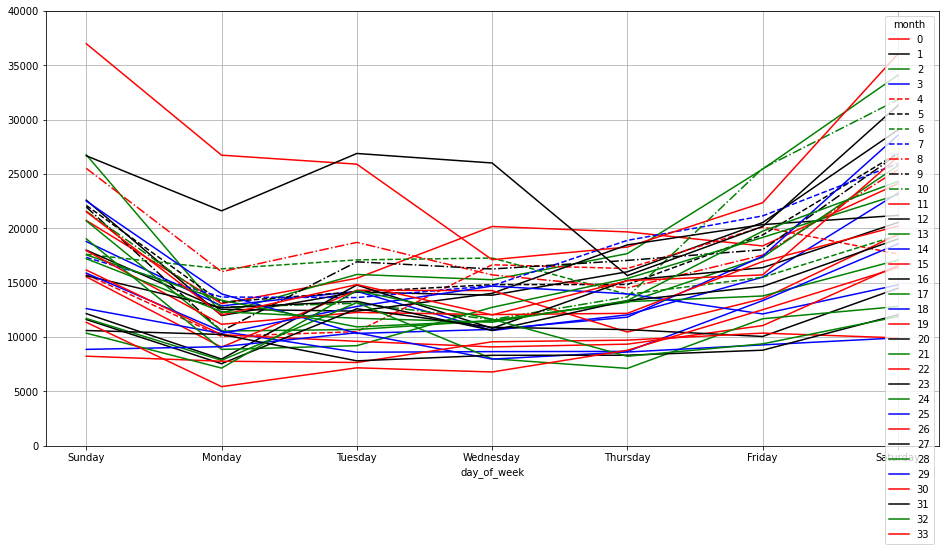

In [35]:
# Now, let's group by month instead of quarter, while still taking the sales for every day in the training set
#   but, also group by day of week, so we will see how big the weekly peaks (seen in plot above)
#   are for each month from 2013 to 2015

dfmDoW = tt.groupby(['month','day_of_week']).agg({'sales':['sum','mean','std']}).reset_index()
dfmDoW.columns = ['month','day_of_week','sales','mean','std']
display(dfmDoW.head())
print('\n')
dfmDoWpiv = pd.pivot(dfmDoW,'day_of_week','month','sales').drop(34,axis=1)   # test is month 34 (0 sales)
dfmDoWpiv = dfmDoWpiv.reindex(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
display(dfmDoWpiv.head())
print('\n')

ax = dfmDoWpiv.plot(kind='line',grid=True,figsize=(16,8), color=color, style=linestyles)
ax.set_ylim(0,40000)
plt.show()

In [36]:
dfmDoW2 = tt[tt.month<34].groupby(['month','day_of_week']).agg({'sales':['sum']}).reset_index()
dfmDoW2.columns = ['month','day_of_week','sales']
display(dfmDoW2.head())
dfmDoW2piv = pd.pivot(dfmDoW2, index = 'month', columns = 'day_of_week', values = 'sales')
dfmDoW2piv = dfmDoW2piv.reindex(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], axis=1)
dfmDoW2piv_cols = dfmDoW2piv.columns
display(dfmDoW2piv.head())
print(f'\n dfmDoW2piv shape = {dfmDoW2piv.shape}')
display(dfmDoW2piv.describe())

,month,day_of_week,sales
0,0,Friday,18372
1,0,Monday,13067
2,0,Saturday,24100
3,0,Sunday,20717
4,0,Thursday,19662


day_of_week,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
month,,,,,,,
0,20717,13067,15399,20162,19662,18372,24100
1,22583,11971,14130,13842,15995,20523,29046
2,26756,12193,15751,15264,17667,25435,34076
3,18779,12858,14198,10596,12036,15501,23222
4,15740,10060,10486,16639,16296,20118,17630



 dfmDoW2piv shape = (34, 7)


day_of_week,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
count,34,34,34,34,34,34,34
mean,"17,920.412","11,808.441","13,381.912","12,854.235","13,341.853","16,263.353","21,607.294"
std,"6,004.235","4,046.100","4,313.225","3,890.887","3,461.607","4,503.688","6,889.363"
min,8231,5431,7161,6779,7109,8782,9914
25%,"13,340.500","9,343.750","10,535.500","10,624.500","10,508.250","12,714.250","16,706.500"
50%,17575,11568,13128,"11,830.500",13515,16656,20853
75%,"21,551.750","13,014.750",14657,14789,15576,"19,644.500",26414
max,36975,26721,26877,26003,19662,25504,36028


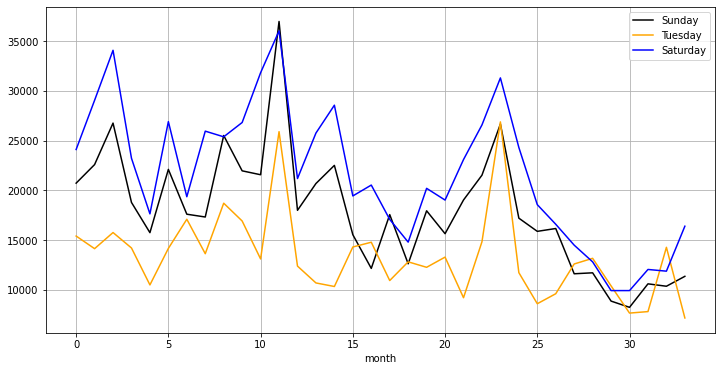

In [37]:
# This plot shows the weekday sales for each weekday over a given month

ax = dfmDoW2piv.plot(y='Sunday',kind='line',grid=True,figsize=(12,6),color='black')
#dfmDoW2piv.plot(x='month',y='Monday',kind='line',grid=True, ax=ax, color='red')
dfmDoW2piv.plot(y='Tuesday',kind='line',grid=True, ax=ax, color='orange')
#dfmDoW2piv.plot(x='month',y='Wednesday',kind='scatter',grid=True, ax=ax, color='magenta')
#dfmDoW2piv.plot(x='month',y='Thursday',kind='scatter',grid=True, ax=ax, color='cyan')
#dfmDoW2piv.plot(x='month',y='Friday',kind='scatter',grid=True, ax=ax, color='brown')
dfmDoW2piv.plot(y='Saturday',kind='line',grid=True, ax=ax, color='blue')
plt.show()

In [38]:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
for compare_day in days:
    compare_cols = [e for e in dfmDoW2piv_cols if e not in ('month', compare_day)]
    new_colnames = [compare_day[:3]+'_'+c[:3] for c in compare_cols]
    for idx in range(len(compare_cols)):
        dfmDoW2piv[new_colnames[idx]] = dfmDoW2piv[compare_day] - dfmDoW2piv[compare_cols[idx]]

print(dfmDoW2piv.shape)
display(dfmDoW2piv.head())

(34, 49)


day_of_week,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sun_Mon,Sun_Tue,Sun_Wed,Sun_Thu,Sun_Fri,Sun_Sat,...,Thu_Sat,Fri_Sun,Fri_Mon,Fri_Tue,Fri_Wed,Fri_Thu,Fri_Sat,Sat_Sun,Sat_Mon,Sat_Tue,Sat_Wed,Sat_Thu,Sat_Fri
month,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20717,13067,15399,20162,19662,18372,24100,7650,5318,555,1055,2345,-3383,...,-4438,-2345,5305,2973,-1790,-1290,-5728,3383,11033,8701,3938,4438,5728
1,22583,11971,14130,13842,15995,20523,29046,10612,8453,8741,6588,2060,-6463,...,-13051,-2060,8552,6393,6681,4528,-8523,6463,17075,14916,15204,13051,8523
2,26756,12193,15751,15264,17667,25435,34076,14563,11005,11492,9089,1321,-7320,...,-16409,-1321,13242,9684,10171,7768,-8641,7320,21883,18325,18812,16409,8641
3,18779,12858,14198,10596,12036,15501,23222,5921,4581,8183,6743,3278,-4443,...,-11186,-3278,2643,1303,4905,3465,-7721,4443,10364,9024,12626,11186,7721
4,15740,10060,10486,16639,16296,20118,17630,5680,5254,-899,-556,-4378,-1890,...,-1334,4378,10058,9632,3479,3822,2488,1890,7570,7144,991,1334,-2488


In [39]:
# Simple print routine to make it easier to plot a bunch of stuff
compare_day = 'Saturday'
color = ['black','red','orange','cyan','blue','purple','brown','pink']
compare_cols = [e for e in dfmDoW2piv_cols if e not in ('month', compare_day)]
new_colnames = [compare_day[:3]+'_'+c[:3] for c in compare_cols]
print(f'ax = dfmDoW2piv.plot(y="{new_colnames[0]}",kind="line",grid=True,figsize=(8,8),color="{color[0]}")')
for i,c in enumerate(new_colnames[1:]):
    print(f'dfmDoW2piv.plot(y="{c}",kind="line",grid=True,ax=ax,color="{color[i]}")')

ax = dfmDoW2piv.plot(y="Sat_Sun",kind="line",grid=True,figsize=(8,8),color="black")
dfmDoW2piv.plot(y="Sat_Mon",kind="line",grid=True,ax=ax,color="black")
dfmDoW2piv.plot(y="Sat_Tue",kind="line",grid=True,ax=ax,color="red")
dfmDoW2piv.plot(y="Sat_Wed",kind="line",grid=True,ax=ax,color="orange")
dfmDoW2piv.plot(y="Sat_Thu",kind="line",grid=True,ax=ax,color="cyan")
dfmDoW2piv.plot(y="Sat_Fri",kind="line",grid=True,ax=ax,color="blue")


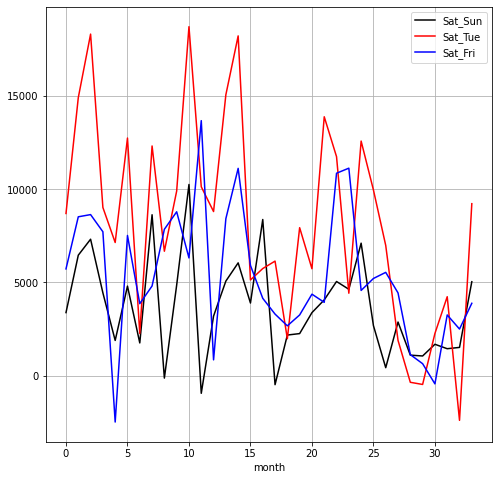

In [40]:
# This plot shows the *difference* in each weekday sales for a given month
ax = dfmDoW2piv.plot(y="Sat_Sun",kind="line",grid=True,figsize=(8,8),color="black")
#dfmDoW2piv.plot(y="Sat_Mon",kind="line",grid=True,ax=ax,color="black")
dfmDoW2piv.plot(y="Sat_Tue",kind="line",grid=True,ax=ax,color="red")
#dfmDoW2piv.plot(y="Sat_Wed",kind="line",grid=True,ax=ax,color="orange")
#dfmDoW2piv.plot(y="Sat_Thu",kind="line",grid=True,ax=ax,color="cyan")
dfmDoW2piv.plot(y="Sat_Fri",kind="line",grid=True,ax=ax,color="blue")
plt.show()

In [41]:
print(dfmDoW2piv[['Sat_Sun','Sat_Mon','Sat_Tue','Sat_Wed','Sat_Thu','Sat_Fri']].describe())

day_of_week   Sat_Sun   Sat_Mon    Sat_Tue    Sat_Wed    Sat_Thu   Sat_Fri
count              34        34         34         34         34        34
mean        3,686.882 9,798.853  8,225.382  8,753.059  8,265.441 5,343.941
std         2,710.911 5,117.563  5,478.416  5,727.587  5,078.520 3,570.543
min              -947       809      -2398        109        206     -2488
25%              1702      6340       4601  4,154.750  3,977.500 3,268.500
50%         3,382.500      9537       8320  9,012.500  7,661.500 4,692.500
75%              5049     13417 12,179.500 12,492.250 11,340.500      7820
max             10257     21883      18723      20217      18131     13682


In [42]:
print(dfmDoW2piv[['Sat_Sun','Sat_Mon','Sat_Tue','Sat_Wed','Sat_Thu','Sat_Fri']].iloc[:26,:].describe())

day_of_week   Sat_Sun    Sat_Mon    Sat_Tue    Sat_Wed    Sat_Thu   Sat_Fri
count              26         26         26         26         26        26
mean        4,238.692 11,324.346  9,933.962 10,223.962  9,530.654 6,182.308
std         2,786.683  4,605.210  4,725.625  5,539.931  5,004.059 3,542.198
min              -947       3086       1982        109        828     -2488
25%              2364  8,737.500  6,278.500  5,977.250  5,493.750      3988
50%              4254 10,703.500       9464 10,133.500       9830 5,821.500
75%         5,806.750 14,469.750 12,708.250      13924 12,446.250 8,497.750
max             10257      21883      18723      20217      18131     13682


In [43]:
print(dfmDoW2piv[['Sat_Sun','Sat_Mon','Sat_Tue','Sat_Wed','Sat_Thu','Sat_Fri']].iloc[26:,:].describe())

day_of_week   Sat_Sun   Sat_Mon   Sat_Tue   Sat_Wed   Sat_Thu   Sat_Fri
count               8         8         8         8         8         8
mean        1,893.500      4841 2,672.500 3,972.625 4,153.500 2,619.250
std         1,450.691 3,314.583 3,956.295 3,299.990 2,624.490 2,048.161
min               428       809     -2398       235       206      -440
25%         1,089.750 2,062.250      -385      1553      3059 1,007.250
50%              1481      4843      2078 3,660.500      3762      2879
75%         1,982.250 6,517.750 4,923.750      5479 6,082.250 4,022.250
max              5040     10957      9227      9609      7613      5542


In [0]:
# We should consider weighting each month's sales, or having an extra column to describe the number of days in the month,
#    and how many of these days are Saturdays (substantially larger sales), Sundays, and Fridays (big sale days also):
#                                Sunday    Monday   Tuesday   Wednesday   Thursday    Friday   Saturday
# mean sales per month (0-33):   17,700    11,700   13,300    12,800      13,200      16,000   21,300

# we could multiply each month's sales by the fraction of such days compared to the test month (nov 2015) (i.e., normalize each month's sales)

# sales seem to slow near the end of our training data, and differences in sales by day of the week also seem far less prominent than earlier months
#   from stock market records, it seems as if Russia had a minor recession in mid-2015, and just started to emerge in Oct/Nov 2015... perhaps there is a good measure of personal spending, better than stock prices
#    (i.e., is there a Personal Consumption Expenditures (PCE) index for Russia like in the US?)
# maybe we should exclude xmas-new year spikes and a few other anomalies (just remove them from dataframe), then do linear regression to find slope and offset of sales per day for each day
#  then use that set of 7 equations (one per weekday) and count of number of each one of the week days in a month, then normalize to what the sales would be for each month if each month
#  had the same number and distribution of days as Nov 2015

# perhaps also then go back and clip sales per day (or similar metric) to conform to these linear fits, so as to reduce the effect of spikes in sales around new year and late feb, etc.
#  because we don't want these spiky features to be lagged into future months

#4. EDA Related to Shop Location and Sales Correlation with Local Holidays

In [48]:
print(f'tt DataFrame: shape = {tt.shape}')
display(tt.head())
day_district = tt.groupby(['day','district']).agg({'month':'mean', 'week':'mean','day_of_month':'mean','sales':'sum'}).reset_index()
districts = day_district.district.unique()
#districts = ['Central', 'Eastern', 'None', 'Northwestern', 'Siberian', 'South', 'Ural', 'Volga']
print(f'\nday_district DataFrame: shape = {day_district.shape}')
display(day_district.head())

tt DataFrame: shape = (3150043, 26)


,day,day_of_week,day_of_month,week,quarter,season,month,price,sales,shop_id,item_id,item_name,it_test,item_category_id,item_category_name,it_cat_test,item_cat3,item_cat4,shop_name,sh_cat,sh_test,district,fd_popdens,fd_gdp,city,population
0,0,Tuesday,1,0,0,2,0,99,1,2,991,"3D Action Puzzle ""Dinosaur"" Tyrannosaurus",False,67,Gifts - Development,True,Gifts,Gifts,"Adygea TC ""Mega""",Mega,True,South,Intermediate,Low,Adygea,144055
1,0,Tuesday,1,0,0,2,0,2599,1,2,1472,Assassin's Creed 3 [Xbox 360 Russian version],False,23,Games - XBOX 360,True,Games,Xbox,"Adygea TC ""Mega""",Mega,True,South,Intermediate,Low,Adygea,144055
2,0,Tuesday,1,0,0,2,0,249,1,2,1905,"Bestseller. Grand Theft Auto: San Andreas [PC, Jewel]",True,30,Games PC - Standard Edition,True,Games,PC,"Adygea TC ""Mega""",Mega,True,South,Intermediate,Low,Adygea,144055
3,0,Tuesday,1,0,0,2,0,599,2,2,2920,"Disney. LEGO Pirates of the Caribbean (Essentials) [PSP, Russian version]",False,21,Games - PSP,True,Games,PlayStation,"Adygea TC ""Mega""",Mega,True,South,Intermediate,Low,Adygea,144055
4,0,Tuesday,1,0,0,2,0,1999,1,2,3320,"FIFA 13 (with support for PS Move) [PS3, Russian version]",False,19,Games - PS3,True,Games,PlayStation,"Adygea TC ""Mega""",Mega,True,South,Intermediate,Low,Adygea,144055



day_district DataFrame: shape = (8249, 6)


,day,district,month,week,day_of_month,sales
0,0,Central,0,0,1,1347
1,0,Northwestern,0,0,1,118
2,0,Siberian,0,0,1,184
3,0,South,0,0,1,69
4,0,Ural,0,0,1,136


In [60]:
# Pivot the data to get plottable columns for district sales by day

# Option to divide "Central" sales by 10 to get on same scale as other districts
day_district_piv = day_district.pivot(index='day',columns='district',values='sales').reset_index().rename_axis("",axis=1).fillna(0)
print(day_district_piv.shape)
#dfdist1.Central = round(dfdist.Central/10)
display(day_district_piv.head())
print('\n')
display(day_district_piv.describe())
print('\n\n')

# also create a version of the table, using scaled versions of all districts (and clipping at (0, 99th ptile)), for easier comparison
qt = day_district_piv.quantile(0.99)
sc = MinMaxScaler((0,100))
day_district_piv_sc = day_district_piv.copy(deep=True)
for dist in districts:
    day_district_piv_sc[dist] = day_district_piv_sc[dist].clip(0,qt[dist])
    day_district_piv_sc[dist] = sc.fit_transform(day_district_piv_sc[dist].to_numpy().reshape(-1,1))
display(day_district_piv_sc.head())
print('\n')
display(day_district_piv_sc.describe())

(1035, 9)


,day,Central,Eastern,None,Northwestern,Siberian,South,Ural,Volga
0,0,1347,0,0,118,184,69,136,97
1,1,5759,0,0,234,496,411,531,767
2,2,4713,407,1,289,426,367,497,722
3,3,4158,391,0,262,352,343,466,645
4,4,3936,492,0,247,398,314,360,599


,day,Central,Eastern,None,Northwestern,Siberian,South,Ural,Volga
count,1035,1035,1035,1035,1035,1035,1035,1035,1035
mean,517.028,"2,027.747",232.712,153.987,230.245,209.377,135.752,202.640,328.347
std,298.973,994.540,123.664,274.219,108.537,101.854,67.976,103.714,152.797
min,0,0,0,-2,0,0,0,0,0
25%,258.500,1330,154,60,166.500,138,90,133,219.500
50%,517,1817,211,103,208,186,120,177,296
75%,775.500,2512,280,158,266,260,165,246,400
max,1063,8229,1129,3748,1287,853,616,843,1228


,day,Central,Eastern,None,Northwestern,Siberian,South,Ural,Volga
0,0,25.987,0,0,16.273,28.721,17.708,24.190,11.548
1,1,100,0,0,32.271,77.423,100.000,94.447,91.312
2,2,90.927,57.546,0.061,39.855,66.496,94.185,88.400,85.954
3,3,80.219,55.284,0,36.132,54.945,88.025,82.886,76.788
4,4,75.936,69.564,0,34.063,62.125,80.583,64.032,71.311


,day,Central,Eastern,None,Northwestern,Siberian,South,Ural,Volga
count,1035,1035,1035,1035,1035,1035,1035,1035,1035
mean,517.028,38.846,32.530,8.877,31.545,32.566,34.649,35.814,38.890
std,298.973,17.977,15.421,12.416,13.681,15.326,16.526,17.453,17.333
min,0,0,0,0,0,0,0,0,0
25%,258.500,25.659,21.774,3.651,22.962,21.541,23.097,23.656,26.132
50%,517,35.055,29.833,6.268,28.685,29.033,30.796,31.482,35.239
75%,775.500,48.464,39.589,9.614,36.684,40.584,42.345,43.755,47.620
max,1063,100,100.000,100,100,100.000,100.000,100,100


In [61]:
# let's enumerate the top sales days, and see if they correlate with local holidays, etc.
# First, gather up all the top sales days for each district and jam them all into a
#    short dataframe with only enough rows to contain all the top sales days for each district
# Use the dataframe version without min-max scaling

topsales = pd.DataFrame({'day':[0]})
for d in districts:
    day_dist_sort = day_district_piv.sort_values(d, ascending=False)
    topsales = topsales.merge(day_dist_sort[['day',d]].iloc[:50,:],on='day',how='outer')
topsales.drop(0, inplace=True)
print(f'Top Sales Days for Each District\nShape: {topsales.shape}')
display(topsales.head(10))

bottomsales = pd.DataFrame({'day':[0]})
for d in districts:
    day_dist_sort = day_district_piv.sort_values(d, ascending=True)
    bottomsales = bottomsales.merge(day_dist_sort[['day',d]].iloc[:50,:],on='day',how='outer')
bottomsales.drop(1,inplace=True)
print(f'\nBottom Sales Days for Each District\nShape: {bottomsales.shape}')
display(bottomsales.head(10))

Top Sales Days for Each District
Shape: (152, 9)


,day,Central,Northwestern,Siberian,South,Ural,Volga,Eastern,None
1,361,8229,809,779,532,746,1194,1003,nan
2,728,8096,854,699,476,648,1036,1084,nan
3,363,7738,888,695,444,665,1228,1102,nan
4,362,7252,1287,853,509,843,1063,1031,nan
5,729,6280,736,708,616,694,945,1129,nan
6,725,6067,883,685,389,672,964,964,nan
7,53,5879,395,589,399,568,900,728,nan
8,364,5844,739,605,321,663,1061,1099,nan
9,1,5759,nan,496,411,531,767,nan,nan
10,726,5392,585,741,438,687,841,767,nan



Bottom Sales Days for Each District
Shape: (220, 9)


,day,Central,Northwestern,Siberian,South,Ural,Volga,Eastern,None
0,0,nan,nan,nan,nan,nan,97,0,0
2,862,630,nan,58,59,68,110,92,nan
3,1030,655,nan,nan,nan,60,108,93,nan
4,1008,655,nan,91,nan,nan,121,nan,nan
5,863,659,97,78,47,72,141,93,nan
6,1007,664,nan,58,57,79,144,64,nan
7,1028,672,nan,nan,56,74,97,nan,nan
8,861,673,97,93,48,58,119,66,nan
9,1021,678,nan,86,nan,68,119,84,nan
10,987,682,89,nan,nan,nan,133,94,nan


In [62]:
# Fill in the empty DataFrame cells with actual values, so every row is fully populated
#   also, add back in a column showing the calendar date to help us distinguish what is a holiday vs. not

day_district_piv = day_district_piv.sort_values('day')
day_district_piv.set_index('day',drop=False,inplace=True)

topsales= topsales.sort_values('day')
topsales.set_index('day',drop=False,inplace=True)
topdays = topsales.day.to_list()

bottomsales = bottomsales.sort_values('day')
bottomsales.set_index('day',drop=False,inplace=True)
bottomdays = bottomsales.day.to_list()

topfill = day_district_piv.iloc[topdays,:] 
bottomfill = day_district_piv.iloc[bottomdays,:] 

topsales = topsales.fillna(topfill)
bottomsales = bottomsales.fillna(bottomfill)

topsales['date'] = topsales.day.apply(lambda x: str(datetime.datetime(2013,1,1)+datetime.timedelta(days=x)).split()[0] )
bottomsales['date'] = bottomsales.day.apply(lambda x: str(datetime.datetime(2013,1,1)+datetime.timedelta(days=x)).split()[0] )

print('\n',topsales.shape)
display(topsales.head(10))
print('\n',bottomsales.shape)
display(bottomsales.head(10))



 (152, 10)


,day,Central,Northwestern,Siberian,South,Ural,Volga,Eastern,None,date
day,,,,,,,,,,
1,1,5759,234,496,411,531,767,0,0,2013-01-02
2,2,4713,289,426,367,497,722,407,1,2013-01-03
3,3,4158,262,352,343,466,645,391,0,2013-01-04
4,4,3936,247,398,314,360,599,492,0,2013-01-05
18,18,3791,262,386,264,416,511,414,0,2013-01-19
25,25,4067,246,342,123,465,609,404,11,2013-01-26
26,26,3472,178,309,119,440,475,280,0,2013-01-27
32,32,3746,247,398,201,435,580,532,6,2013-02-02
39,39,4304,331,409,227,401,642,488,0,2013-02-09



 (220, 10)


,day,Central,Northwestern,Siberian,South,Ural,Volga,Eastern,None,date
day,,,,,,,,,,
0,0,1347,118,184,69,136,97,0,0,2013-01-01
1,1,5759,234,496,411,531,767,0,0,2013-01-02
2,2,4713,289,426,367,497,722,407,1,2013-01-03
3,3,4158,262,352,343,466,645,391,0,2013-01-04
4,4,3936,247,398,314,360,599,492,0,2013-01-05
5,5,3768,196,346,235,381,580,352,0,2013-01-06
6,6,3303,193,266,261,346,483,132,0,2013-01-07
7,7,3067,200,249,189,269,388,405,5,2013-01-08
11,11,3496,203,286,201,310,604,343,0,2013-01-12


In [63]:
print(topsales.date.to_list)
print('\n')
print(bottomsales.date.to_list)

<bound method IndexOpsMixin.tolist of day
1       2013-01-02
2       2013-01-03
3       2013-01-04
4       2013-01-05
18      2013-01-19
           ...    
1002    2015-09-30
1003    2015-10-01
1004    2015-10-02
1005    2015-10-03
1006    2015-10-04
Name: date, Length: 152, dtype: object>


<bound method IndexOpsMixin.tolist of day
0       2013-01-01
1       2013-01-02
2       2013-01-03
3       2013-01-04
4       2013-01-05
           ...    
1028    2015-10-26
1029    2015-10-27
1030    2015-10-28
1031    2015-10-29
1032    2015-10-30
Name: date, Length: 220, dtype: object>


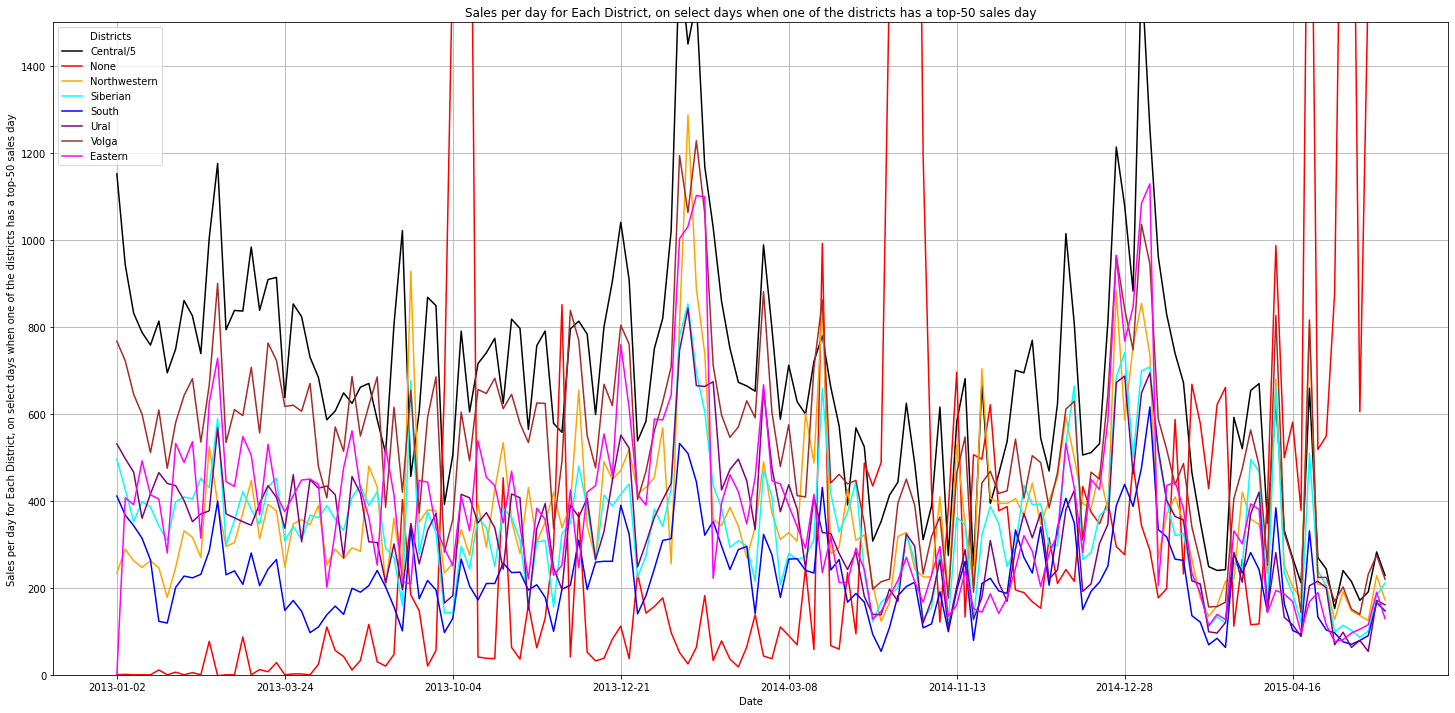

In [65]:

gtp = 'day' # group_time_period
gc = 'district'  # group_category

topsales2 = topsales.iloc[:,:].copy(deep=True)  
topsales2.Central = topsales2.Central/5
ax = topsales2.plot(x="date",y="Central",kind="line",grid=True,figsize=(25,12),color="black",label="Central/5")
topsales2.plot(x="date",y="None",kind="line",ax=ax,color="red")
topsales2.plot(x="date",y="Northwestern",kind="line",ax=ax,color="orange")
topsales2.plot(x="date",y="Siberian",kind="line",ax=ax,color="cyan")
topsales2.plot(x="date",y="South",kind="line",ax=ax,color="blue")
topsales2.plot(x="date",y="Ural",kind="line",ax=ax,color="purple")
topsales2.plot(x="date",y="Volga",kind="line",ax=ax,color="brown")
topsales2.plot(x="date",y="Eastern",kind="line",grid=True,ax=ax,color="magenta")
ax.set_title(f"Sales per {gtp} for Each District, on select days when one of the districts has a top-50 sales day")
ax.legend(title="Districts")
ax.set_ylabel(f"Sales per {gtp} for Each District, on select days when one of the districts has a top-50 sales day")
ax.set_xlabel(f"Date")

ax.set_ylim(0,1500)
plt.show()

# Offline sales:
# peaks at 2013: Sept 17, Oct 29, Nov 22, Nov 26; 2014: peak on 5/27* and from oct2-9 (max oct 4*); 2015: April 14*, May 19*, Sept 29 and Sept 30
#   no rise at xmas 2013
#   no rise at xmas 2014, but Jan 2015 had a broad, moderately-high peak

# * every district except Eastern and Ural had a decent uptick on 5/27/14... it was a Muslim holiday
# * every district had at least a small uptick around Oct 4, 2014  (again, Muslim holiday)
# * every district has a bump up on April 14, 2015 (day after Easter?) and 5/19/15 

# South sales:
#  only small rise at xmas 2013

# Central:
#   largest rise at xmas 2013, but close to proportionate relative to all other districts except online and south
#   significant increase throughout Dec. 2014

Plotted at: Thu 17:14:01 06/11/20



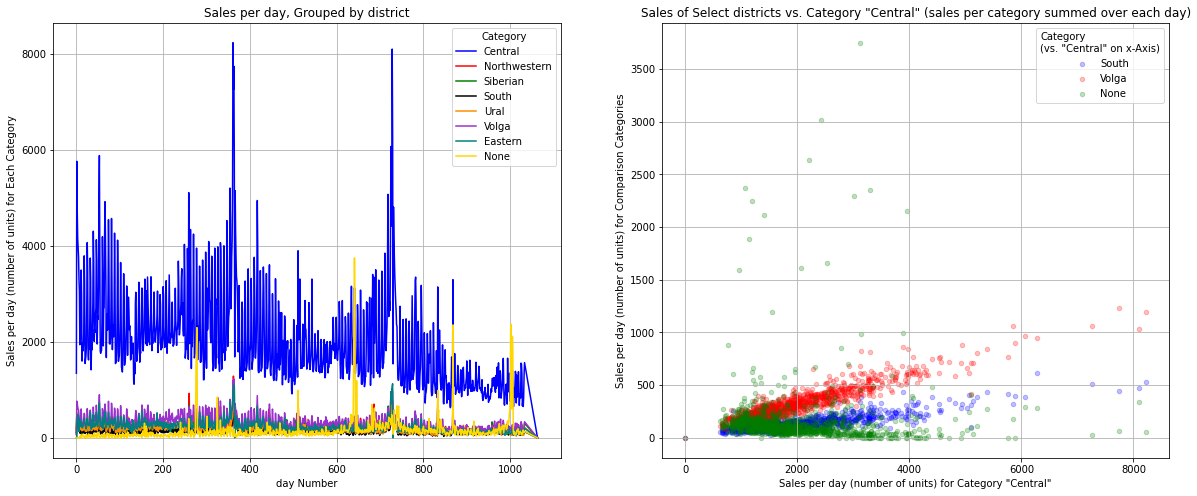

In [67]:
# #sns.pairplot(cat_cat.iloc[:][:4])  # can't seem to get this multiple-plot grid to work in a reasonable amount of time (even with GPU, stopped this 2x2 grid afer 20min of incompletion)
pltcolors = ['blue','red','green','black','darkorange','darkorchid','teal', 'gold','olive','firebrick','gray','sienna','fuchsia','dodgerblue','cyan','lime','deeppink','violet','turquoise','tan']

# Look at line plots of the above


'''
Line Plot Inputs & Parameters
'''
categories_for_line_plot = districts  # x-axis is index (time period)
line_colors = pltcolors[:len(categories_for_line_plot)]
# if desired, set axis limits using bool or tuple:
line_plot_x = False  # False uses auto-scale
line_plot_y = False #(-10,1000)

'''
Scatter Plot Inputs & Parameters
'''
x_scatter_plot_category = ['Central']
y_scatter_plot_categories = ['South','Volga','None'] #12,15] #,70]
scatter_alphas = 0.25 #[1.0, 0.25, 0.25, 0.25]          # set transparency to see dots behind other dots
scatter_plot_x = False #(20,40) #False  # False uses auto-scale
scatter_plot_y = False #(-10,200)


print(f'Plotted at: {strftime("%a %X %x")}\n')

'''
Generate the Plots
'''
fig = plt.figure(figsize=(20,8)) 
axLine = fig.add_subplot(1,2,1)
axLine.set_title(f'Sales per {gtp}, Grouped by {gc}')
axScatter = fig.add_subplot(1,2,2)
axScatter.set_title(f'Sales of Select {gc}s vs. Category "{x_scatter_plot_category[0]}" (sales per category summed over each {gtp})')

day_district_piv.plot(y=categories_for_line_plot, kind='line',color=line_colors,grid=True, ax=axLine)

for sidx, s in enumerate(y_scatter_plot_categories):
    day_district_piv.plot.scatter(x=x_scatter_plot_category,y=s,color=pltcolors[sidx], grid=True, ax=axScatter, label=str(s), alpha=scatter_alphas) #[sidx])

axLine.legend(title='Category')
axLine.set_ylabel(f'Sales per {gtp} (number of units) for Each Category')
axLine.set_xlabel(f'{gtp} Number')
axScatter.legend(title=f'Category\n(vs. "{x_scatter_plot_category[0]}" on x-Axis)')
axScatter.set_ylabel(f'Sales per {gtp} (number of units) for Comparison Categories')
axScatter.set_xlabel(f'Sales per {gtp} (number of units) for Category "{x_scatter_plot_category[0]}"')
if line_plot_x:
    axLine.set_xlim(line_plot_x)
if line_plot_y:
    axLine.set_ylim(line_plot_y)
if scatter_plot_x:
    axScatter.set_xlim(scatter_plot_x)
if scatter_plot_y:
    axScatter.set_ylim(scatter_plot_y)

plt.show()

In [69]:
# Using the Scalar'ed version of the data table, compute differences in sales between districts to get time trend differences
day_district_piv_sc2 = day_district_piv_sc.copy(deep=True)
for compare_dist in districts:
    compare_cols = [e for e in districts if e not in ('day', compare_dist)]
    new_colnames = [compare_dist[:4]+'_'+c[:4] for c in compare_cols]
    for idx in range(len(compare_cols)):
        day_district_piv_sc2[new_colnames[idx]] = day_district_piv_sc2[compare_dist] - day_district_piv_sc2[compare_cols[idx]]

print(day_district_piv_sc2.shape)
display(day_district_piv_sc2.head())

(1035, 65)


,day,Central,Eastern,None,Northwestern,Siberian,South,Ural,Volga,Cent_Nort,Cent_Sibe,Cent_Sout,Cent_Ural,...,East_Nort,East_Sibe,East_Sout,East_Ural,East_Volg,East_None,None_Cent,None_Nort,None_Sibe,None_Sout,None_Ural,None_Volg,None_East
0,0,25.987,0,0,16.273,28.721,17.708,24.190,11.548,9.714,-2.734,8.280,1.798,...,-16.273,-28.721,-17.708,-24.190,-11.548,0,-25.987,-16.273,-28.721,-17.708,-24.190,-11.548,0
1,1,100,0,0,32.271,77.423,100.000,94.447,91.312,67.729,22.577,-0.000,5.553,...,-32.271,-77.423,-100.000,-94.447,-91.312,0,-100,-32.271,-77.423,-100.000,-94.447,-91.312,0
2,2,90.927,57.546,0.061,39.855,66.496,94.185,88.400,85.954,51.072,24.431,-3.258,2.527,...,17.691,-8.950,-36.639,-30.854,-28.408,57.485,-90.866,-39.795,-66.435,-94.124,-88.339,-85.894,-57.485
3,3,80.219,55.284,0,36.132,54.945,88.025,82.886,76.788,44.088,25.274,-7.806,-2.666,...,19.152,0.339,-32.742,-27.602,-21.504,55.284,-80.219,-36.132,-54.945,-88.025,-82.886,-76.788,-55.284
4,4,75.936,69.564,0,34.063,62.125,80.583,64.032,71.311,41.873,13.811,-4.647,11.905,...,35.501,7.439,-11.019,5.532,-1.747,69.564,-75.936,-34.063,-62.125,-80.583,-64.032,-71.311,-69.564


In [70]:
# Pick a single district to compare against, and this code will print out the code lines
#    needed to make a line plot overlaying the differences between each of the other 
#    districts and the disctrict you picked
compare_dist = 'Central'
color = ['black','red','orange','cyan','blue','purple','brown','pink']
compare_cols = [e for e in districts if e not in ('day', compare_dist)]
new_colnames = [compare_dist[:4]+'_'+c[:4] for c in compare_cols]
print(f'ax = day_district_piv_sc2.plot(x="day",y="{new_colnames[0]}",kind="line",grid=True,figsize=(25,12),color="{color[0]}")')
for i,c in enumerate(new_colnames[1:]):
    print(f'day_district_piv_sc2.plot(x="day",y="{c}",kind="line",ax=ax,color="{color[i+1]}")')

print('ax.set_title(f"Sales of Districts Compared to District: {compare_dist}")')
print('ax.legend(title="Compared Districts")')
print('ax.set_ylabel(f"Sales per {gtp} for Each District, Subtracted From {compare_dist} Sales, With SKLearn Scaler")')
print('ax.set_xlabel(f"{gtp} Number")')

ax = day_district_piv_sc2.plot(x="day",y="Cent_Nort",kind="line",grid=True,figsize=(25,12),color="black")
day_district_piv_sc2.plot(x="day",y="Cent_Sibe",kind="line",ax=ax,color="red")
day_district_piv_sc2.plot(x="day",y="Cent_Sout",kind="line",ax=ax,color="orange")
day_district_piv_sc2.plot(x="day",y="Cent_Ural",kind="line",ax=ax,color="cyan")
day_district_piv_sc2.plot(x="day",y="Cent_Volg",kind="line",ax=ax,color="blue")
day_district_piv_sc2.plot(x="day",y="Cent_East",kind="line",ax=ax,color="purple")
day_district_piv_sc2.plot(x="day",y="Cent_None",kind="line",ax=ax,color="brown")
ax.set_title(f"Sales of Districts Compared to District: {compare_dist}")
ax.legend(title="Compared Districts")
ax.set_ylabel(f"Sales per {gtp} for Each District, Subtracted From {compare_dist} Sales, With SKLearn Scaler")
ax.set_xlabel(f"{gtp} Number")


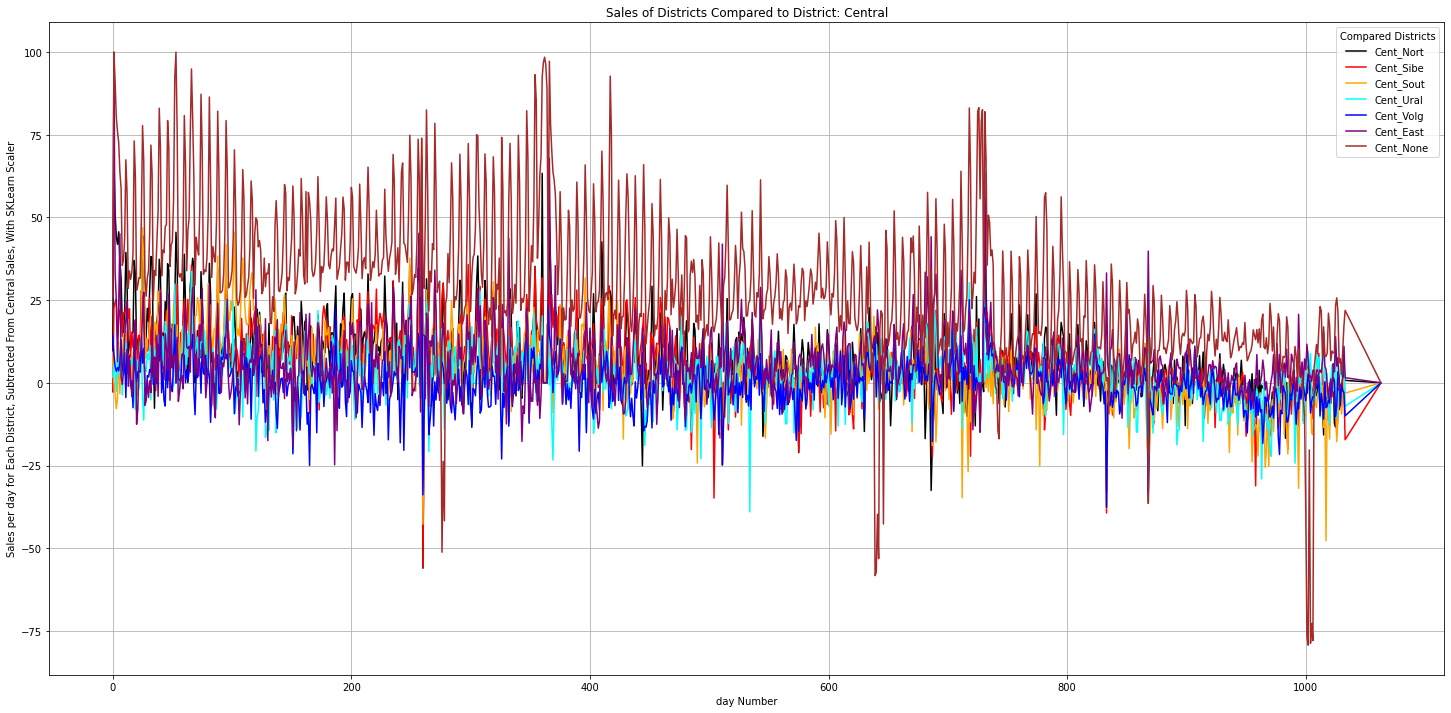

In [73]:
# # paste the above text into this code block to make the plot; comment out lines if you don't want them included

ax = day_district_piv_sc2.plot(x="day",y="Cent_Nort",kind="line",grid=True,figsize=(25,12),color="black")
day_district_piv_sc2.plot(x="day",y="Cent_Sibe",kind="line",ax=ax,color="red")
day_district_piv_sc2.plot(x="day",y="Cent_Sout",kind="line",ax=ax,color="orange")
day_district_piv_sc2.plot(x="day",y="Cent_Ural",kind="line",ax=ax,color="cyan")
day_district_piv_sc2.plot(x="day",y="Cent_Volg",kind="line",ax=ax,color="blue")
day_district_piv_sc2.plot(x="day",y="Cent_East",kind="line",ax=ax,color="purple")
day_district_piv_sc2.plot(x="day",y="Cent_None",kind="line",grid=True,ax=ax,color="brown")
ax.set_title(f"Sales of Districts Compared to District: {compare_dist}")
ax.legend(title="Compared Districts")
ax.set_ylabel(f"Sales per {gtp} for Each District, Subtracted From {compare_dist} Sales, With SKLearn Scaler")
ax.set_xlabel(f"{gtp} Number")

#ax.set_ylim(-25,25)
plt.show()

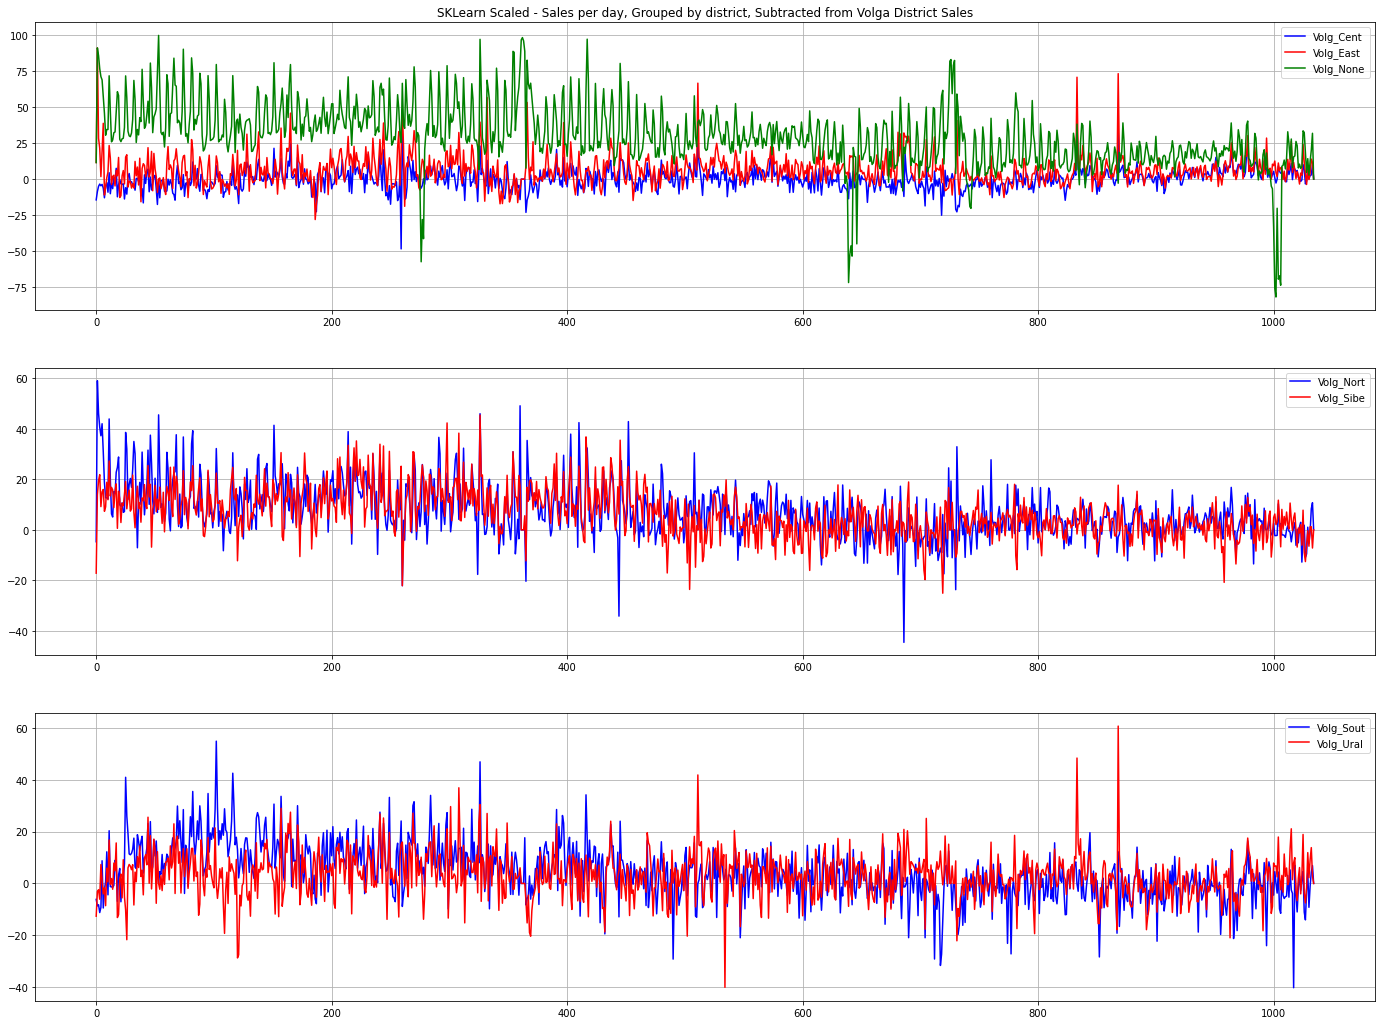

In [75]:
# '''
# Line Plot Inputs & Parameters
# '''
categories_for_line_plot = ['Volg_Cent','Volg_East','Volg_None','Volg_Nort','Volg_Sibe','Volg_Sout','Volg_Ural'] #dfdist0.district.unique()  # x-axis is index (time period)
line_colors = pltcolors[:len(categories_for_line_plot)]
# if desired, set axis limits using bool or tuple:
line_plot_x = False  # False uses auto-scale
line_plot_y = False #(-10,1000)

fig = plt.figure(figsize=(24,18)) 

axLine1 = fig.add_subplot(3,1,1)
axLine1.set_title(f'SKLearn Scaled - Sales per {gtp}, Grouped by {gc}, Subtracted from Volga District Sales')

axLine2 = fig.add_subplot(3,1,2)
axLine3 = fig.add_subplot(3,1,3)

day_district_piv_sc2.plot(y=categories_for_line_plot[:3], kind='line',color=line_colors,grid=True, ax=axLine1)
day_district_piv_sc2.plot(y=categories_for_line_plot[3:5], kind='line',color=line_colors,grid=True, ax=axLine2)
day_district_piv_sc2.plot(y=categories_for_line_plot[5:], kind='line',color=line_colors,grid=True, ax=axLine3)

plt.show()

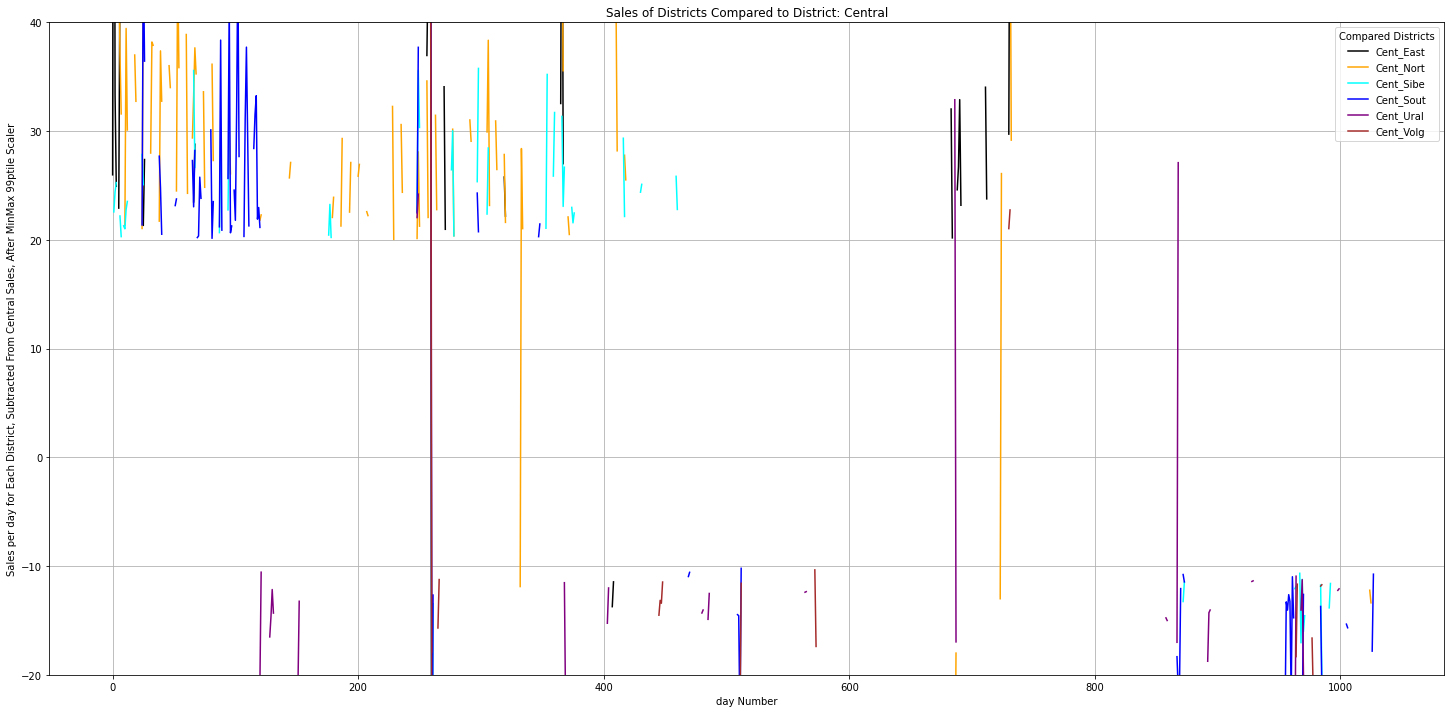

In [76]:
for c in new_colnames:
    day_district_piv_sc2[c] = day_district_piv_sc2[c].apply(lambda x: np.NaN if ((x > -10) and (x < 20)) else x)

ax = day_district_piv_sc2.plot(x="day",y="Cent_East",kind="line",grid=True,figsize=(25,12),color="black")
#day_district_piv_sc2.plot(x="day",y="Cent_None",kind="line",ax=ax,color="red")
day_district_piv_sc2.plot(x="day",y="Cent_Nort",kind="line",ax=ax,color="orange")
day_district_piv_sc2.plot(x="day",y="Cent_Sibe",kind="line",ax=ax,color="cyan")
day_district_piv_sc2.plot(x="day",y="Cent_Sout",kind="line",ax=ax,color="blue")
day_district_piv_sc2.plot(x="day",y="Cent_Ural",kind="line",ax=ax,color="purple")
day_district_piv_sc2.plot(x="day",y="Cent_Volg",kind="line",grid=True,ax=ax,color="brown")
ax.set_title(f"Sales of Districts Compared to District: {compare_dist}")
ax.legend(title="Compared Districts")
ax.set_ylabel(f"Sales per {gtp} for Each District, Subtracted From {compare_dist} Sales, After MinMax 99ptile Scaler") #RobustScaler")
ax.set_xlabel(f"{gtp} Number")

ax.set_ylim(-20,40)
plt.show()

Plotted at: Thu 17:30:49 06/11/20



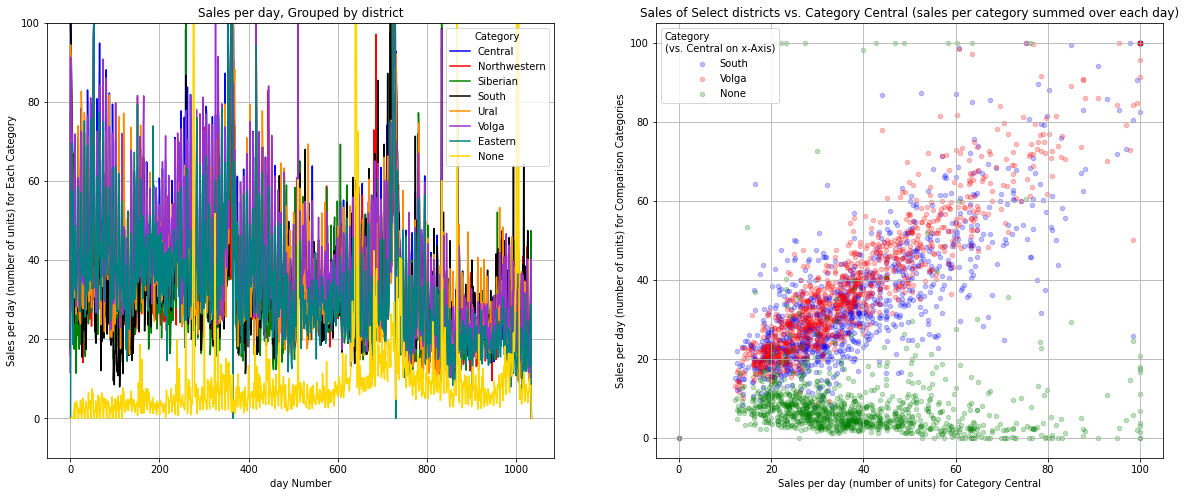

In [77]:
# None (online) "district" is definitely different behavior than other "districts"
# Let's look more closely at comparison of districts by day

# scale each of the columns so we can look at relative differences in sales rather than absolute... StandardScaler

'''
Line Plot Inputs & Parameters
'''
categories_for_line_plot = districts
line_colors = pltcolors[:len(categories_for_line_plot)]
# if desired, set axis limits using bool or tuple:
line_plot_x = False  # False uses auto-scale
line_plot_y = (-10,100)

'''
Scatter Plot Inputs & Parameters
'''
x_scatter_plot_category = ['Central']
y_scatter_plot_categories = ['South','Volga','None'] #12,15] #,70]
scatter_alphas = 0.25 #[1.0, 0.25, 0.25, 0.25]          # set transparency to see dots behind other dots
scatter_plot_x = False #(20,40) #False  # False uses auto-scale
scatter_plot_y = False #(-10,200)

print(f'Plotted at: {strftime("%a %X %x")}\n')

'''
Generate the Plots
'''
fig = plt.figure(figsize=(20,8)) 
axLine = fig.add_subplot(1,2,1)
axLine.set_title(f'Sales per {gtp}, Grouped by {gc}')
axScatter = fig.add_subplot(1,2,2)
axScatter.set_title(f'Sales of Select {gc}s vs. Category {x_scatter_plot_category[0]} (sales per category summed over each {gtp})')

day_district_piv_sc.plot(y=categories_for_line_plot, kind='line',color=line_colors,grid=True, ax=axLine)

for sidx, s in enumerate(y_scatter_plot_categories):
    day_district_piv_sc2.plot.scatter(x=x_scatter_plot_category,y=s,color=pltcolors[sidx], grid=True, ax=axScatter, label=str(s), alpha=scatter_alphas) #[sidx])

axLine.legend(title='Category')
axLine.set_ylabel(f'Sales per {gtp} (number of units) for Each Category')
axLine.set_xlabel(f'{gtp} Number')
axScatter.legend(title=f'Category\n(vs. {x_scatter_plot_category[0]} on x-Axis)')
axScatter.set_ylabel(f'Sales per {gtp} (number of units) for Comparison Categories')
axScatter.set_xlabel(f'Sales per {gtp} (number of units) for Category {x_scatter_plot_category[0]}')
if line_plot_x:
    axLine.set_xlim(line_plot_x)
if line_plot_y:
    axLine.set_ylim(line_plot_y)
if scatter_plot_x:
    axScatter.set_xlim(scatter_plot_x)
if scatter_plot_y:
    axScatter.set_ylim(scatter_plot_y)

plt.show()  # suppresses the printing of matplotlib object above